# Two approaches in dealing with uncertainty
A Bayesian and Frequentist approach to prediction uncertainty. In both cases, I want to define both aleatoric and epistemic uncertainty.

In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import pymc3 as pm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error

from functools import partial
from scipy import stats, interpolate

from src.data import generate_dataset
from src.visualization import beautify_ax
from src.models import (
    BayesianLinearRegression, 
    DeepQuantileRegression, QuantileLoss, 
    HeteroscedasticDropoutNet, gaussian_nll_loss
)
from src.models.quantile_utils import create_quantiles, get_quantile_pred

%load_ext autoreload
%autoreload 2

# Generating data

In [2]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

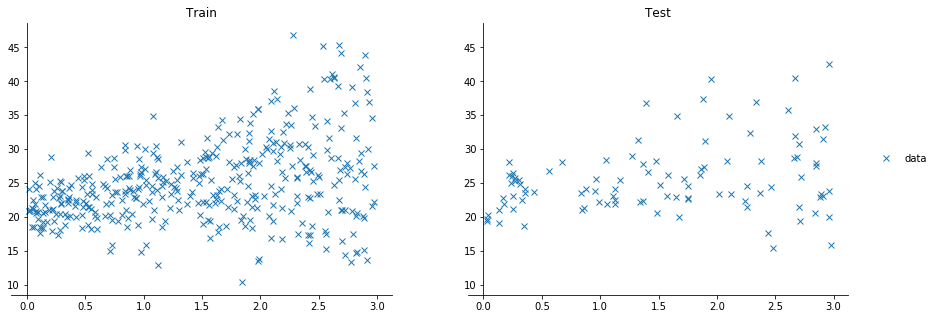

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data

In [4]:
mmsx = MinMaxScaler()
x = mmsx.fit_transform(x)
x_test = mmsx.transform(x_test)

mmsy = MinMaxScaler()
y = mmsy.fit_transform(y)
y_test = mmsy.transform(y_test)

In [5]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

## Loading trace and make predictions from BLR model

In [8]:
fname_trace = '../models/BLR.trace'
blr = BayesianLinearRegression()
blr.load_trace(fname_trace)

In [9]:
blr_preds_train = blr.predict(x)
blr_preds_test = blr.predict(x_test)

blr_preds_test.shape, blr_preds_train.shape

100%|██████████| 4000/4000 [00:40<00:00, 98.37it/s] 


((4000, 100, 1), (4000, 400, 1))

## Load deep quantile regression neural network and make predictions

In [10]:
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
print(f"Used quantiles: {QUANTILES}")
qr_params = {
    'input_size': 1,
    'hidden_size': 128,
    'dropout_p': 0.2,
    'dropout_dim': 1,
    'quantiles': QUANTILES,
    'batch_size': 16,
    'epochs': 2001,
    'lr': 1e-4,
    'weight_decay': 1e-6,
}
dqr = DeepQuantileRegression(qr_params)
dqr.load(path='../models/', fname='deep_quantile_regression.pth')

Used quantiles: [0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]


DeepQuantileRegression(
  (model_): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Dropout_on_dim(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=11, bias=True)
  )
)

In [11]:
dqr_preds_train = dqr.mc_predict(x_train, samples=4000).numpy()
dqr_preds_test = dqr.mc_predict(x_val, samples=4000).numpy()

dqr_preds_test.shape, dqr_preds_train.shape

((4000, 100, 11), (4000, 400, 11))

## Load heteroscedastic MCDropout neural network and make predictions

In [12]:
hdn_params = {
    'input_size': 1,
    'output_size': 2,
    'hidden_size': 256,
    'dropout_p': 0.2,
    'batch_size': 64,
    'epochs': 2001,
    'lr': 1e-4,
}
hdn = HeteroscedasticDropoutNet(hdn_params)
hdn.load(path='../models/', fname='heteroscedastic_mcdropout.pth')

HeteroscedasticDropoutNet(
  (model_): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [13]:
hdn_preds_train = hdn.mc_predict(x_train, samples=4000).numpy()
hdn_preds_test = hdn.mc_predict(x_val, samples=4000).numpy()

hdn_preds_test.shape, hdn_preds_train.shape

((4000, 100, 2), (4000, 400, 2))

## Looking at individual predictions (on test set)
The quantile regressions predicts the quantiles (by design, although we have to take the mean of all cdfs produced by `mc_predict()`), but we have to find the same quantiles from the posterior distribution prediction from the bayesian linear regression model. 
The distributions seem very similar. Maybe we need to plot them in a PDF form.

In [14]:
def postprocess_samples(samples):
    mus = np.mean(samples[:, :, 0], axis=0)
    sigmas = np.mean(np.exp(samples[:, :, 1]), axis=0)
    return mus, sigmas

hdn_mu_test, hdn_sigma_test = postprocess_samples(hdn_preds_test)

In [15]:
random_is = np.random.randint(0, len(x_test), 9)

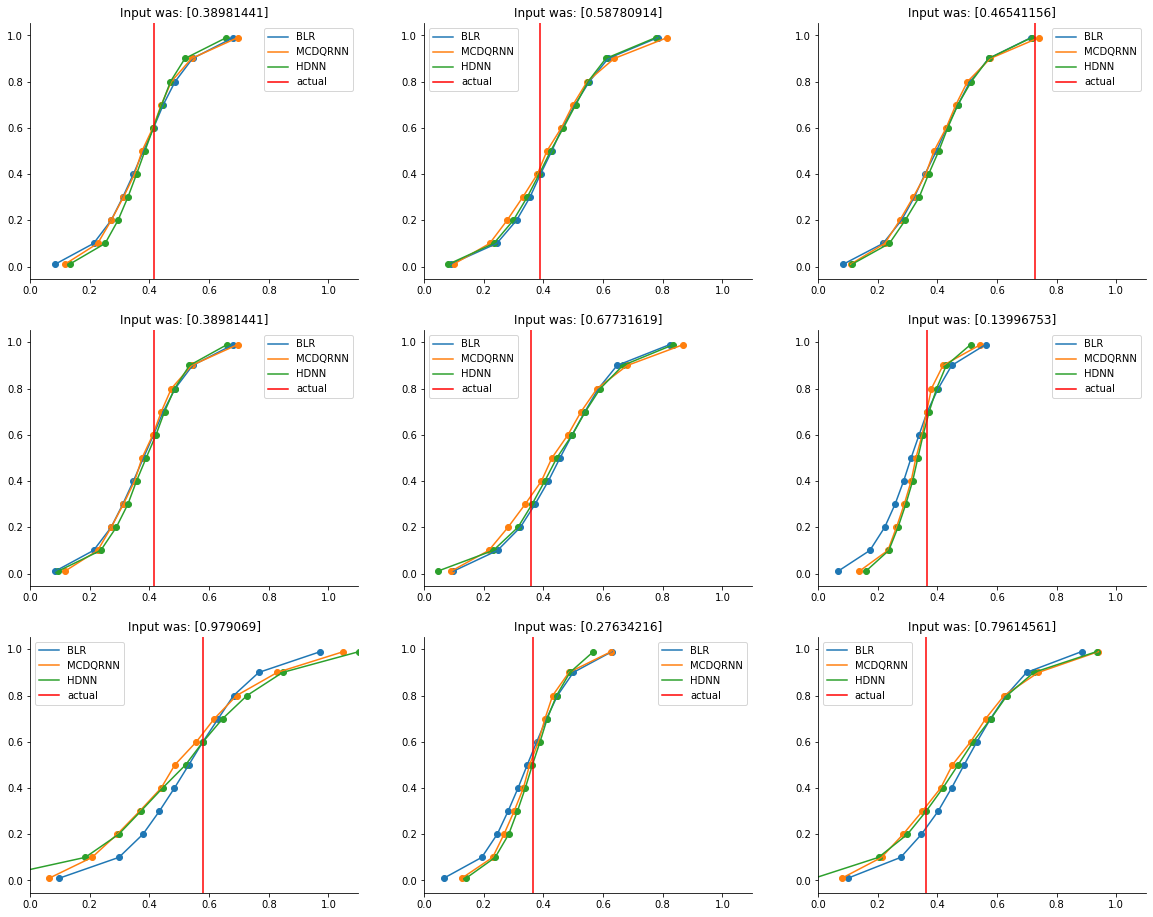

In [16]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    blr_posterior = blr_preds_test[:, i, 0].reshape(-1,1)
    qs_from_posterior = np.quantile(blr_posterior, QUANTILES)
    ax.plot(qs_from_posterior, QUANTILES, label='BLR')
    ax.scatter(qs_from_posterior, QUANTILES)
    
    mean_qs = np.mean(dqr_preds_test[:, i, :], axis=0)
    dqr_posterior = mean_qs.reshape(-1,1)
    ax.plot(dqr_posterior, QUANTILES, label='MCDQRNN')
    ax.scatter(dqr_posterior, QUANTILES)
    
    norm_samples = stats.norm.rvs(size=1000, loc=hdn_mu_test[i], scale=hdn_sigma_test[i])
    qs_from_samples = np.quantile(norm_samples, QUANTILES)
    ax.plot(qs_from_samples, QUANTILES, label='HDNN')
    ax.scatter(qs_from_samples, QUANTILES)

    ax.axvline(y_test[i], c='r', label='actual')
    ax.set_title(f"Input was: {x_test[i]}")
    ax.legend()
    ax.set_xlim(0, 1.1)
    
plt.show()

## Looking at individual predictions - part 2
You can see that the distributions are normally distributed, with different levels of uncertainty. (higher input value of $x$ should result into higher uncertainty). The difference is still difficult to determine. In these samples, the MCDQRNN seems to be overly confident on some predictions, and sometimes with more probability mass towards the edges of the distribution. Maybe we need another plot to compare! At least we can see that both approaches are really similar!

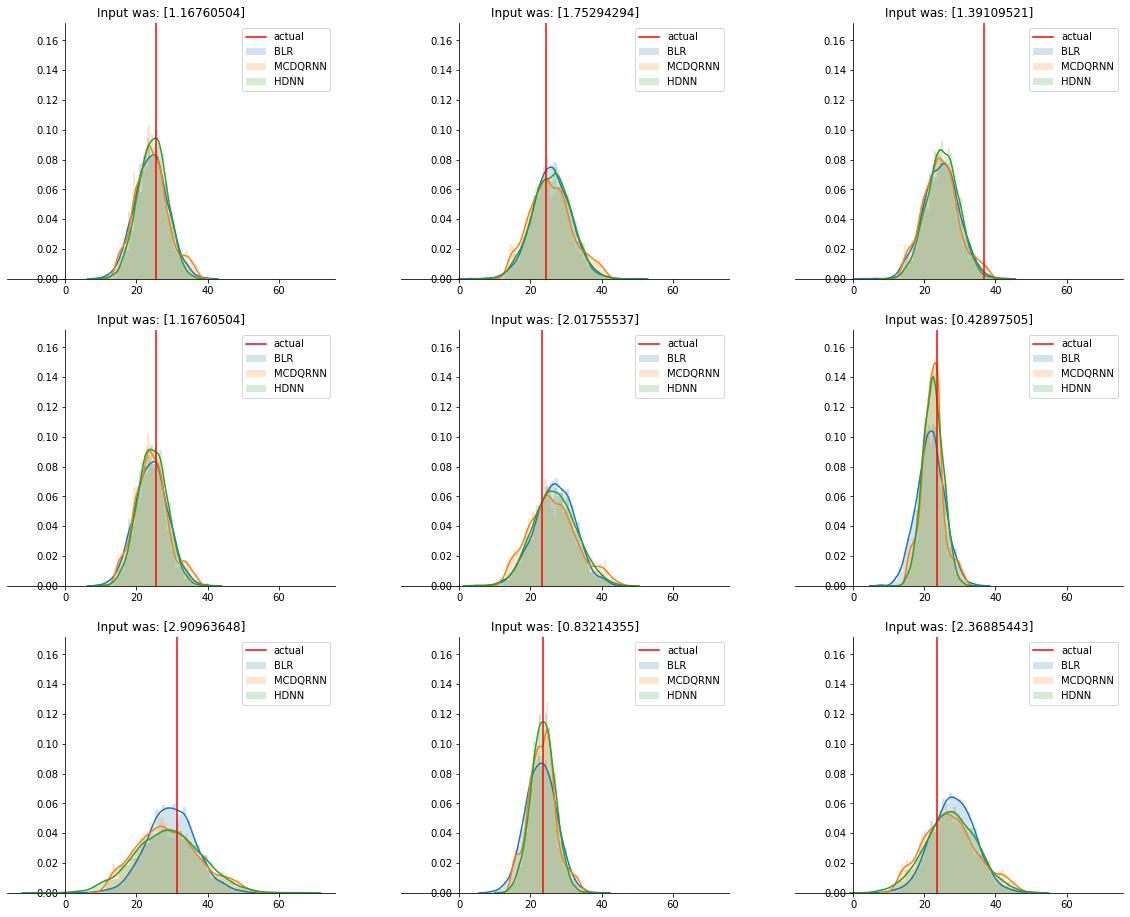

In [38]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    blr_posterior = mmsy.inverse_transform(blr_preds_test[:, i, 0].reshape(-1,1))
    sns.distplot(blr_posterior, bins=50, ax=ax, label='BLR', hist_kws={'alpha':0.2})
    
    dqr_posterior = np.array([
        get_quantile_pred(q=stats.uniform.rvs(), used_quantiles=QUANTILES, preds=dqr_preds_test[s, i, :])
        for s in range(dqr_preds_test.shape[0])  # sample from all samples
    ])
    dqr_posterior = mmsy.inverse_transform(dqr_posterior.reshape(-1,1))
    sns.distplot(dqr_posterior, bins=50, ax=ax, label='MCDQRNN', hist_kws={'alpha':0.2})
    
    norm_samples = stats.norm.rvs(size=4000, loc=mmsy.inverse_transform(hdn_mu_test[i].reshape(-1,1)), scale=hdn_sigma_test[i]/mmsy.scale_)  # bit overkill, but to be completely equal in terms of samples
    sns.distplot(norm_samples, bins=50, ax=ax, label='HDNN', hist_kws={'alpha':0.2})
    
    ax.axvline(mmsy.inverse_transform(y_test[i].reshape(-1,1)), c='r', label='actual')
    ax.set_title(f"Input was: {mmsx.inverse_transform(x_test[i].reshape(-1,1))[0]}")
    ax.legend()
#     ax.set_xlim(0, 60)
    
plt.show()

## Looking at point predictions
As a simple metric, we could compare single point predictions by taking the mean of the predicted posterior distribution. This point is the best value to represent the probability distribution. We could then for example compare the Mean Absolute Error (MAE).

In [40]:
dqr_posteriors = []
for i in tqdm(range(x_test.shape[0])):
    dqr_posteriors.append(np.array([
        get_quantile_pred(q=stats.uniform.rvs(), used_quantiles=QUANTILES, preds=dqr_preds_test[s, i, :])
        for s in range(dqr_preds_test.shape[0])  # sample from all samples
    ]))
dqr_mean_preds = np.mean(np.stack(dqr_posteriors), axis=-1)
dqr_mean_preds = mmsy.inverse_transform(dqr_mean_preds.reshape(-1,1))

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


In [41]:
blr_mean_preds = mmsy.inverse_transform(np.mean(blr_preds_test, axis=0))

In [42]:
norm_samples = mmsy.inverse_transform(np.mean(np.stack([stats.norm.rvs(size=1000, loc=hdn_mu_test[i], scale=hdn_sigma_test[i]) for i in range(len(hdn_sigma_test))]), axis=-1).reshape(-1,1))

The point estimates predictions are really similar!

In [43]:
print("MAE - MCDQRNN : {:.3f}".format(mean_absolute_error(y_test, dqr_mean_preds)))
print("MAE - HDNN    : {:.3f}".format(mean_absolute_error(y_test, norm_samples)))
print("MAE - BLR     : {:.3f}".format(mean_absolute_error(y_test, blr_mean_preds)))

MAE - MCDQRNN : 24.793
MAE - HDNN    : 25.030
MAE - BLR     : 24.974


Until now, we've only visually compared the uncertainty (distributions). But how do we formally evaluate the uncertainty of the model? This is something I will dive into next.